In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [188]:
print(torch.__version__)

1.13.1


In [189]:
print(torch_geometric.__version__)

2.1.0


In [190]:
def correlation_matrix(size, corr):
    corr_matrix = np.zeros((size,size))
    cont = 0

    for i in range(size):
        for j in range(i, size):
            if i == j:
                corr_matrix[i,j] = 0#float('nan')


            else:
                corr_matrix[i,j] = corr[cont]
                corr_matrix[j,i] = corr[cont]
                cont += 1 
    return corr_matrix

In [191]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher200.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices200.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [194]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

#df = ((df.reset_index()).drop(columns=['Institution', 'Subject','Run'])).dropna(subset=[str(x) for x in range(0,61425)])
df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Gender'])
y = (df.Gender).apply(lambda x: int(x))
X = np.tanh(df.iloc[:,:-3])

In [195]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [196]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True)

In [197]:
train_data = []

for i in range((X_train.shape[0])):
    adj = correlation_matrix(190,X_train.iloc[i,:].values)
    np.fill_diagonal(adj,0)
    adj = torch.from_numpy(adj).float()
    edge_index, edge_attr = dense_to_sparse(adj)
    train_data.append(Data(x=adj, edge_index=edge_index, edge_attr=edge_attr.reshape(len(edge_attr), 1),
                            y=torch.tensor(int(y_train.iloc[i]))))

In [198]:
test_data = []

for i in range((X_test.shape[0])):
    adj = correlation_matrix(190,X_test.iloc[i,:].values)
    np.fill_diagonal(adj,1)
    adj = torch.from_numpy(adj).float()
    edge_index, edge_attr = dense_to_sparse(adj)
    test_data.append(Data(x=adj, edge_index=edge_index, edge_attr=edge_attr.reshape(len(edge_attr), 1),
                          y=torch.tensor(int(y_test.iloc[i]))))

In [199]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 35910], edge_attr=[35910, 1], y=1)


In [200]:
from torch_geometric.loader import DataLoader

batch_size = 32

train_loader = DataLoader(train_data, batch_size, shuffle=True)

test_loader = DataLoader(test_data, shuffle=True)


In [201]:
#for data in train_loader:
    #print(batch)
    #print('num_nodes',batch.num_nodes)
    #print(batch.x.shape)
    #print(data.edge_index.shape)
    #print(data.batch)
    #print('num_graphs', batch.num_graphs)
    # data = data.to(device)
    # optimizer.zero_grad()
    # out = model(data.x, data.edge_index, data.batch)
    # loss = F.cross_entropy(out, data.y)
    # loss.backward()
    # optimizer.step()
    # total_loss += float(loss) * data.num_graphs


In [205]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool




class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.1):
        super(GCN, self).__init__()

        self.p = dropout
        
        self.conv1 = GCNConv(int(num_features), 64)
        #self.conv2 = GCNConv(128, 64)
        self.conv2 = GCNConv(64, 32)
        
        #self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        #self.conv2 = ChebConv(128, 64, K=k_order)
        #self.conv3 = ChebConv(64, 32, K=k_order)

        self.lin1 = torch.nn.Linear(32, int(num_classes))
        
        self.max = torch.nn.Softmax(dim=1)
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        
        x = func.relu(self.conv1(x, edge_index))  #, edge_attr))  #WHY NAN WITH EDGE_ATTR?
        x = func.dropout(x, p=self.p, training=self.training)
        x = func.relu(self.conv2(x, edge_index))  #, edge_attr))  #WHY NAN WITH EDGE_ATTR?
        x = func.dropout(x, p=self.p, training=self.training)
        #x = func.relu(self.conv3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)

        
        x = self.pool(x, batch)
        x = self.lin1(x)
        x = self.max(x)
        return x

In [207]:
def GCN_train(loader, loop):
    model.train()

    loss_all = 0
    
    #for data in loader:
        # data = data.to(device)
        # optimizer.zero_grad()
        # output = model(data)
        # loss = func.cross_entropy(output, data.y)
        # loss.backward()
        # optimizer.step()
        # loss_all += data.num_graphs * loss.item()
        # #optimizer.step()
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        loss = func.cross_entropy(output, y.y)
        loss.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss.item()
        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all)
        #optimizer.step()
    return loss_all / len(train_data)


def GCN_test(loader):
    model.eval()

    pred = []
    label = []
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        loss = func.cross_entropy(output, data.y)
        loss_all += data.num_graphs * loss.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_sen = tp / (tp + fn)
    epoch_spe = tn / (tn + fp)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    return epoch_sen, epoch_spe, epoch_acc, loss_all / len(test_data)

loss_ = []
acc_ = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
   
min_v_loss = np.inf  

NUM_EPOCHS = 100
for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    t_loss = GCN_train(train_loader,loop)
    test_sen, test_spe, test_acc, _ = GCN_test(test_loader)
    
    loss_.append(t_loss)
    acc_.append(test_acc)

    

Epoch [1/100]: 100%|██████████████████| 21/21 [00:13<00:00,  1.59it/s, loss=429]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49993/1855663198.py:48: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/100]: 100%|██████████████████| 21/21 [00:09<00:00,  2.32it/s, loss=422]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49993/1855663198.py:48: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/100]: 100%|██████████████████| 21/21 [00:08<00:00,  2.45it/s, loss=413]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49993/1855663198.py:48: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/100]: 100%|██████████████████| 21/21 [00:09<00:00,  2.27it/s, loss=410]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49993/1855663198.py:48: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

In [208]:
y_pred = []
for y in test_loader:
    y_pred.append(model(y))

In [209]:
y_pred[:5]

[tensor([[1.9313e-04, 9.9981e-01]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.0032, 0.9968]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.9989, 0.0011]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.3098, 0.6902]], grad_fn=<SoftmaxBackward0>),
 tensor([[5.1081e-04, 9.9949e-01]], grad_fn=<SoftmaxBackward0>)]

In [210]:
test_acc

0.631578947368421

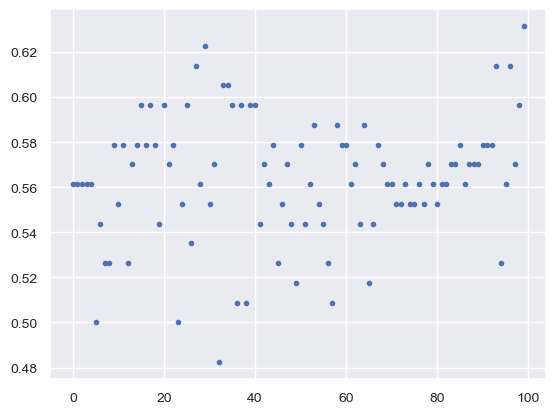

In [220]:
plt.plot(acc_, '.')